# Loading the trained model and Concatenation of the Street Numbers

## 1. Libraries

In [1]:
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image, ImageFont, ImageDraw 
import matplotlib.pyplot as plt
import warnings
import os
import cv2
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline  

## 2. Load the trained Model

In [2]:
PATH_TO_SAVED_MODEL = "../RealTimeObjectDetection/Tensorflow/workspace/models/efficientdetd0/exp_1/freeze_model/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...WARNING:tensorflow:Importing a function (__inference_bifpn_layer_call_and_return_conditional_losses_67107) with ops with custom gradients. Will likely fail if a gradient is requested.


Done! Took 26.200003623962402 seconds


## 3. Load the Labelmap for the detections

In [3]:
PATH_TO_LABELS = "../RealTimeObjectDetection/Tensorflow/workspace/annotations/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

## 4. Detectection and Concatenation of Street Numbers

In [4]:
####function that concatenates the numbers from an image we need an array of arrays with the bounding boxes and an array with the classes
def concatenate(bbs_int,classes,height,width):
    order=np.copy(classes)
    x=np.zeros(order.shape,int) #left
    y=np.zeros(order.shape,int) #top
    w=np.zeros(order.shape,int) #width
    h=np.zeros(order.shape,int) #height
    c=0
    for i in bbs_int:
        x[c]=i[1]*width #top
        y[c]=i[0]*height #left
        w[c]=(i[3]-i[1])*width #width
        h[c]=(i[2]-i[0])*height #height
        c=c+1
        
    ####calculate the total width of the numbers and its average
    sum_width=np.sum(w)
    av_width=np.average(w)

    #### veryfing if the order is from left to right or from top to bottom
    differences_x= np.zeros((order.size-1),int)
    d=0
    for u in x:
        if d<x.size-1:
            differences_x[d]=x[d+1]-u
        d=d+1
    av_differences_x=np.average(differences_x)

    #order from top to bottom
    if 2*(abs(av_differences_x))<av_width: 
        order=order[np.argsort(y)]
    #order from left to right
    else:
        order=order[np.argsort(x)]
    order=order.astype(str)
    order=''.join(order)
    return order

471.png
Running inference for 471.png... 481.png
Running inference for 481.png... 482.png
Running inference for 482.png... 483.png
Running inference for 483.png... 499.png
Running inference for 499.png... 501.png
Running inference for 501.png... 504.png
Running inference for 504.png... 507.png
Running inference for 507.png... 509.png
Running inference for 509.png... 520.png
Running inference for 520.png... 522.png
Running inference for 522.png... 525.png
Running inference for 525.png... 528.png
Running inference for 528.png... 529.png
Running inference for 529.png... 530.png
Running inference for 530.png... 532.png
Running inference for 532.png... 533.png
Running inference for 533.png... 534.png
Running inference for 534.png... 535.png
Running inference for 535.png... 536.png
Running inference for 536.png... 539.png
Running inference for 539.png... 540.png
Running inference for 540.png... 541.png
Running inference for 541.png... 542.png
Running inference for 542.png... 543.png
Running 

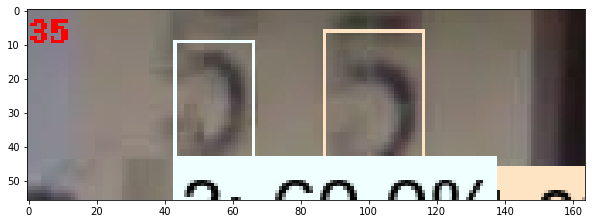

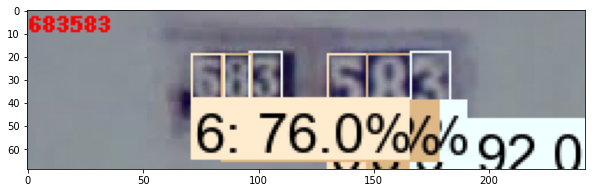

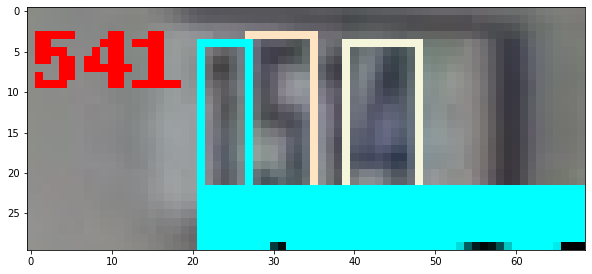

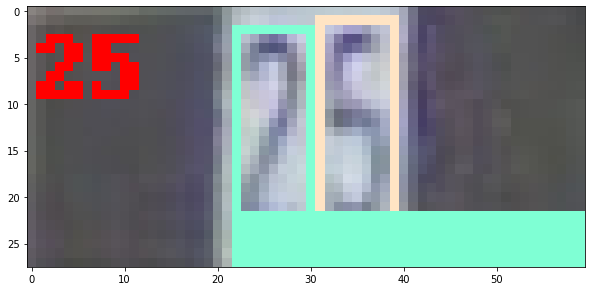

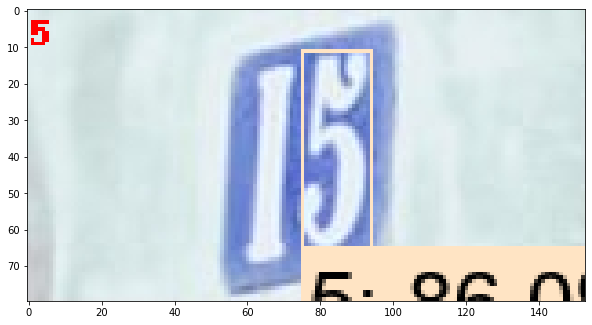

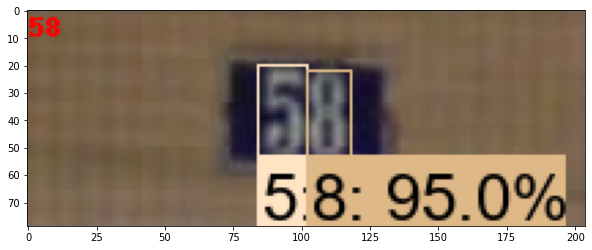

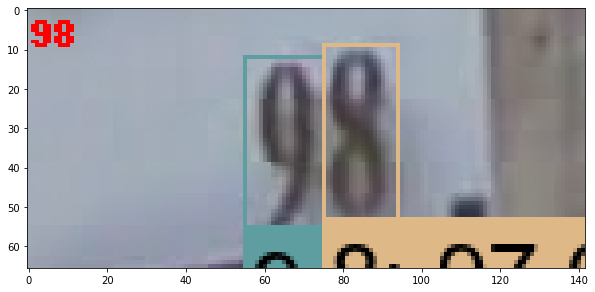

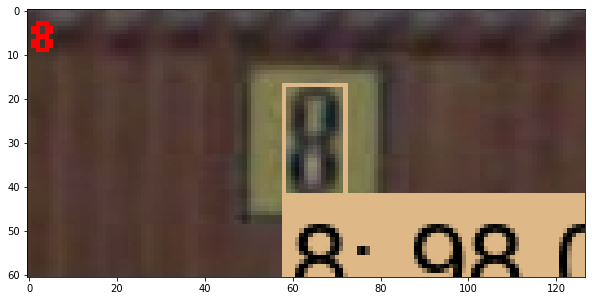

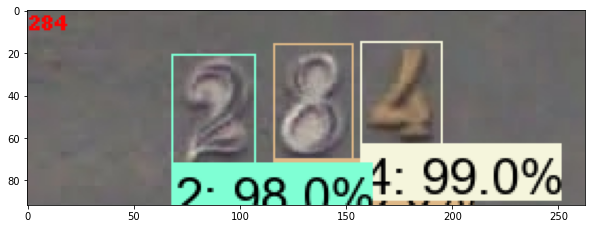

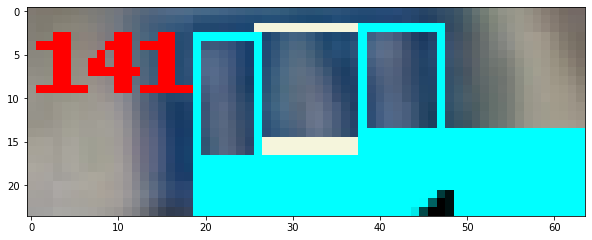

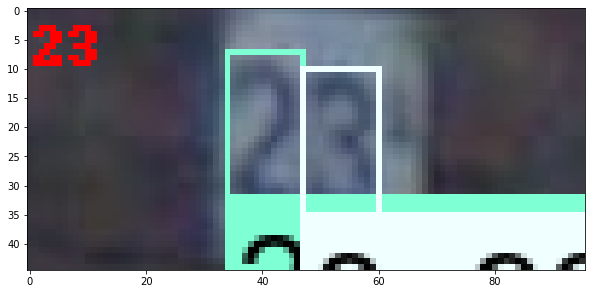

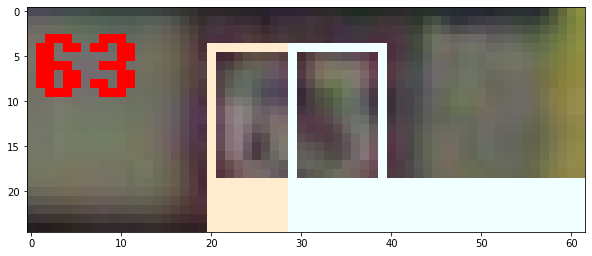

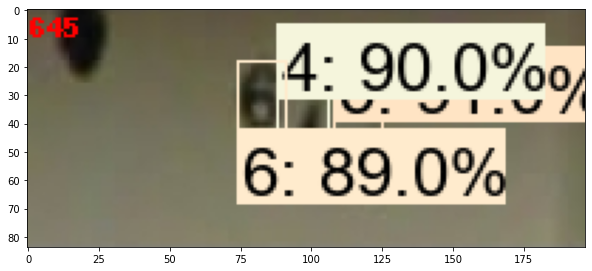

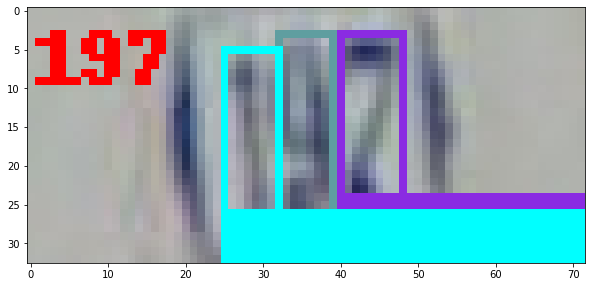

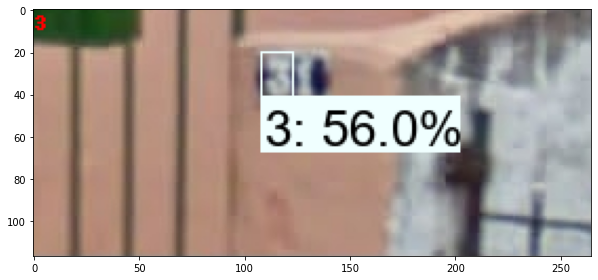

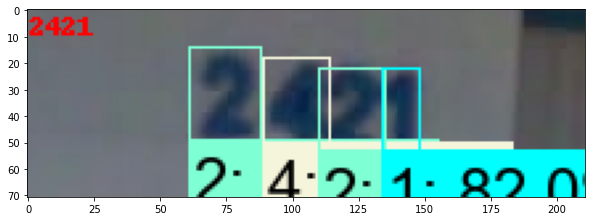

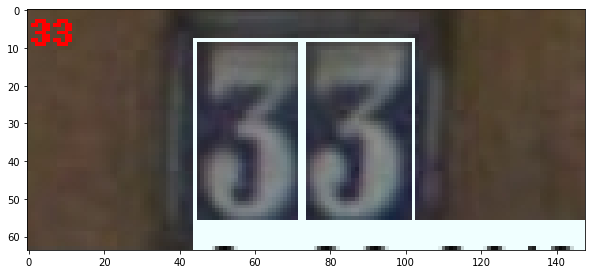

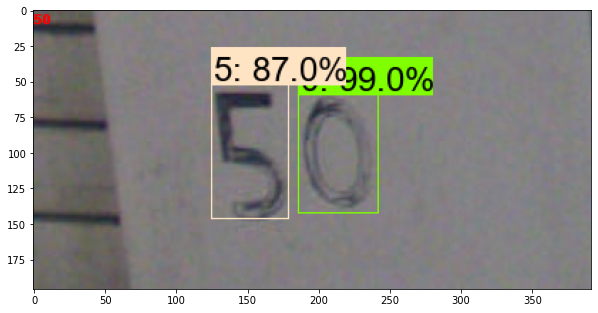

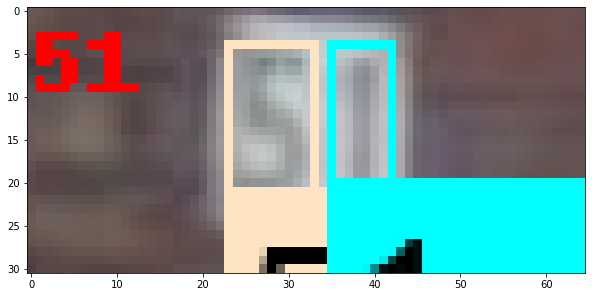

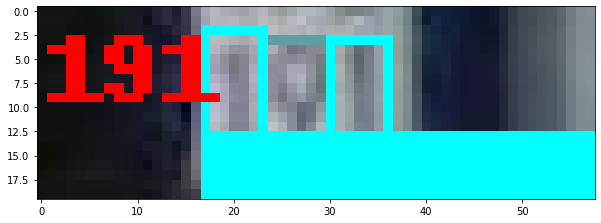

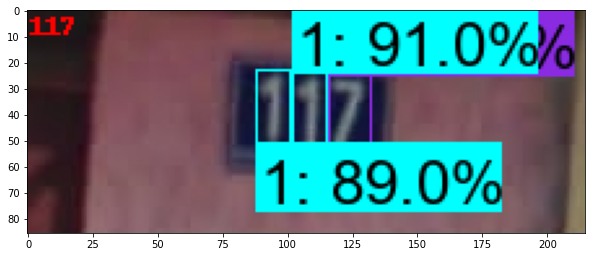

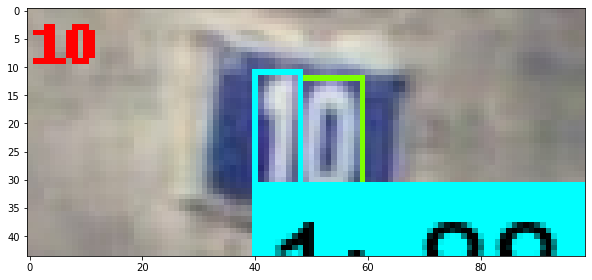

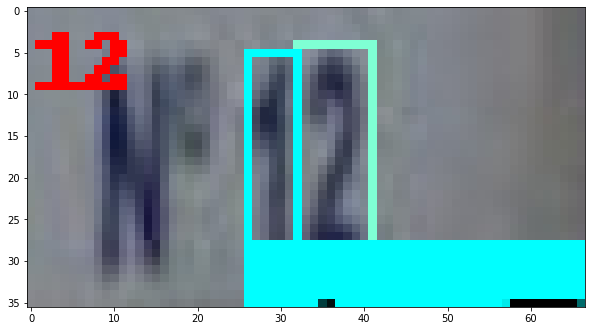

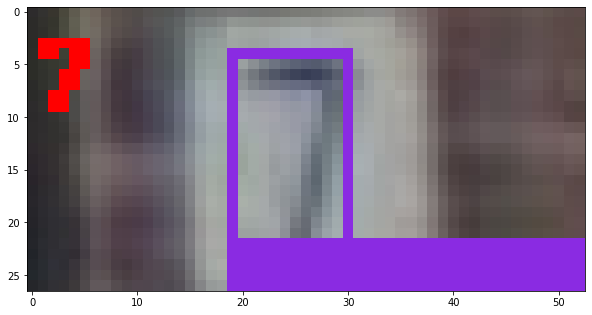

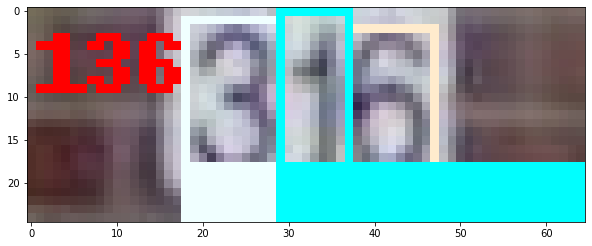

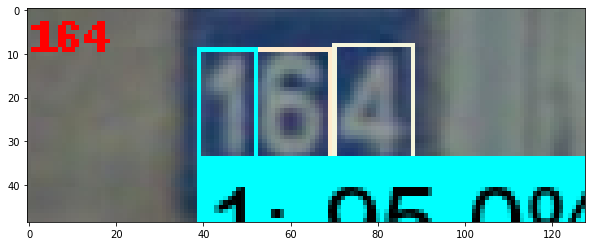

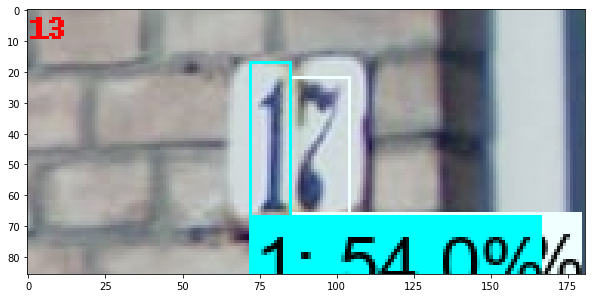

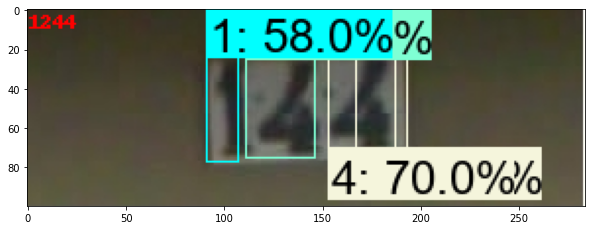

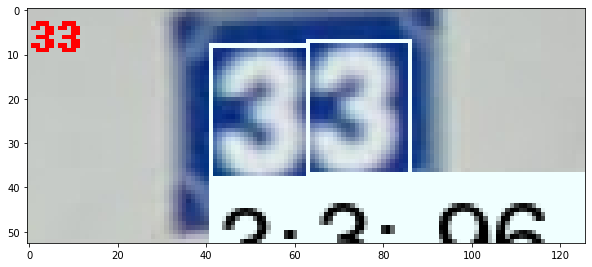

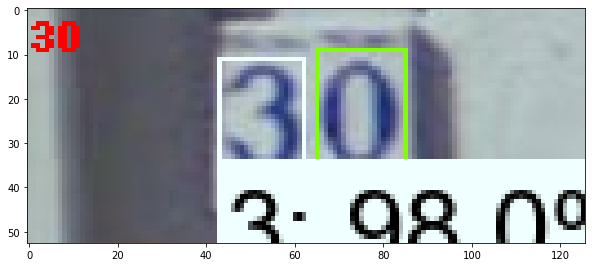

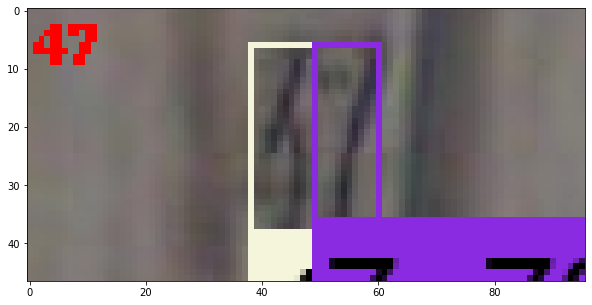

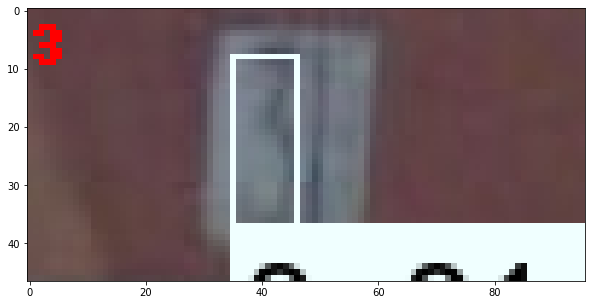

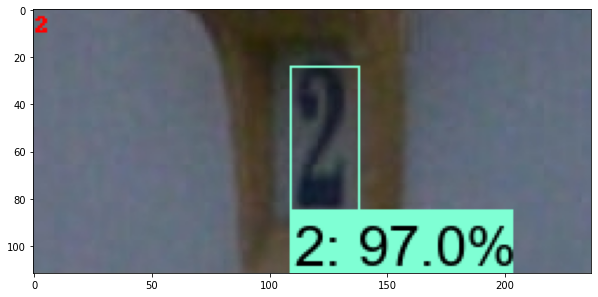

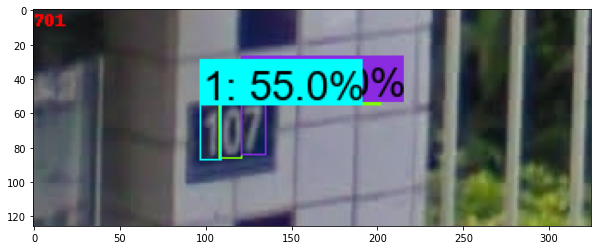

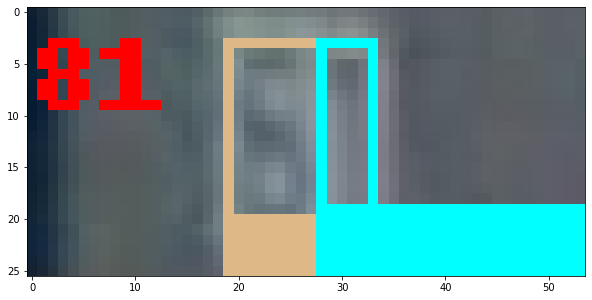

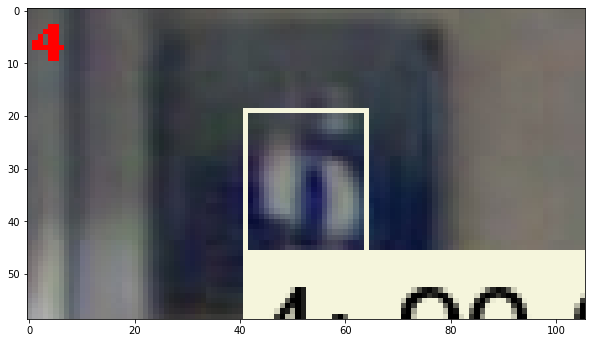

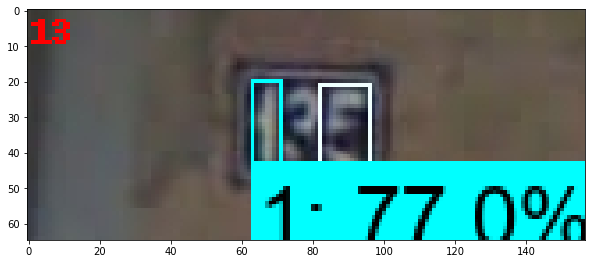

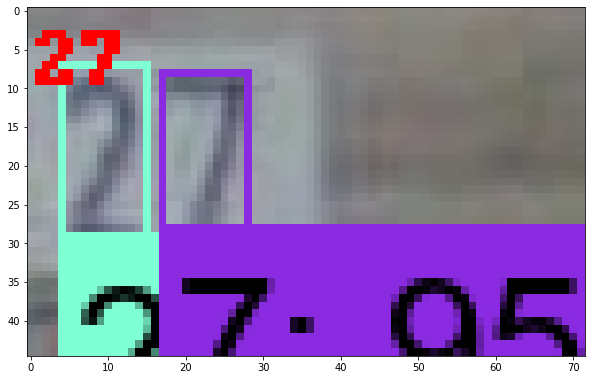

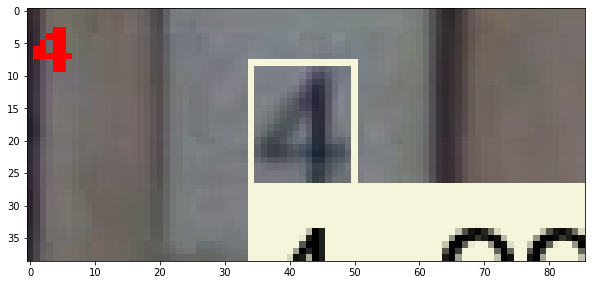

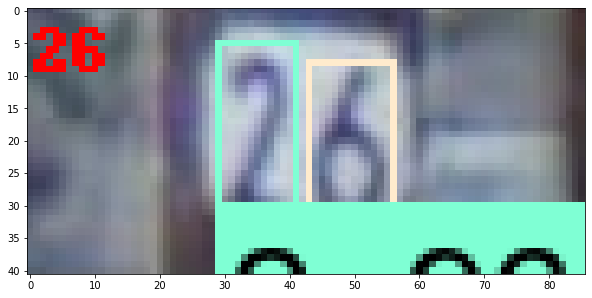

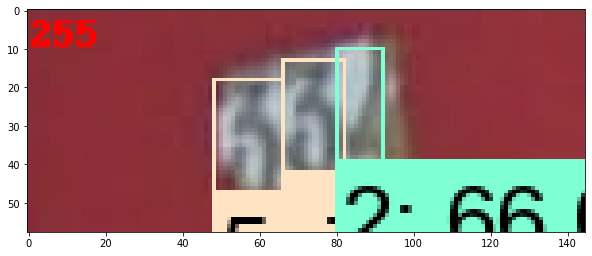

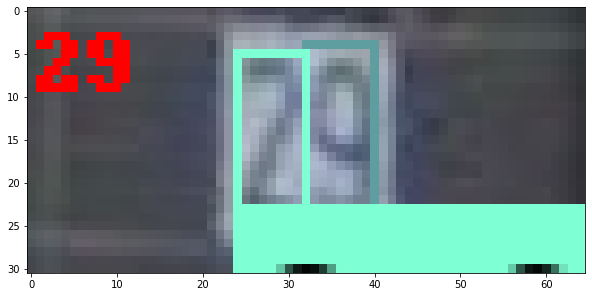

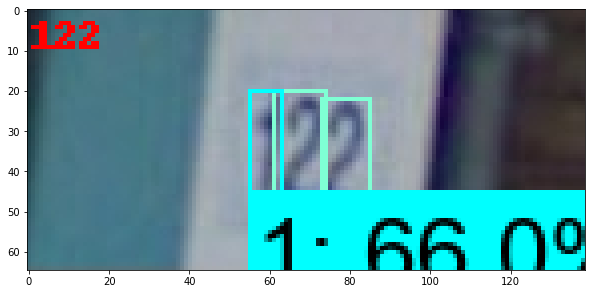

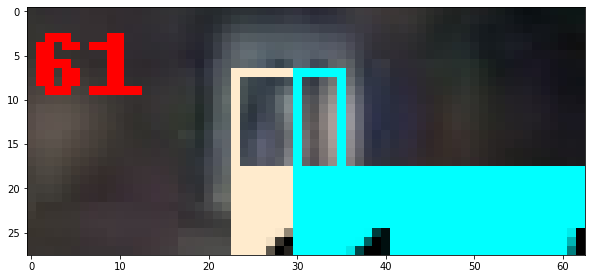

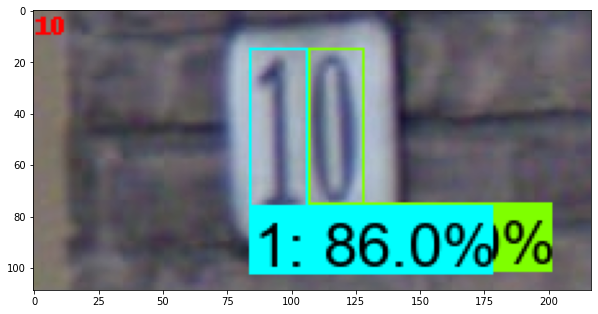

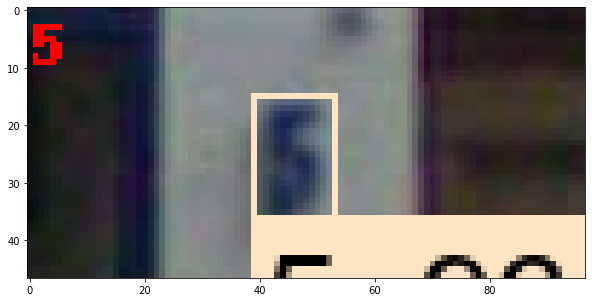

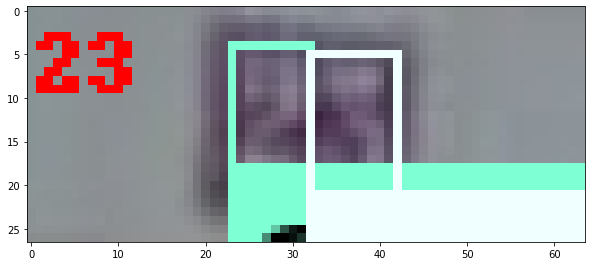

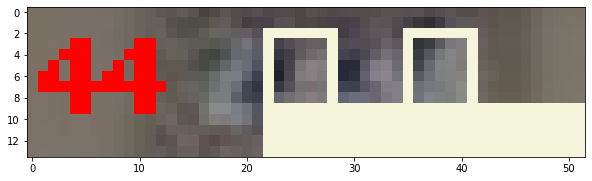

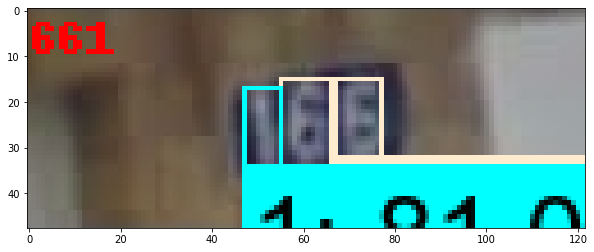

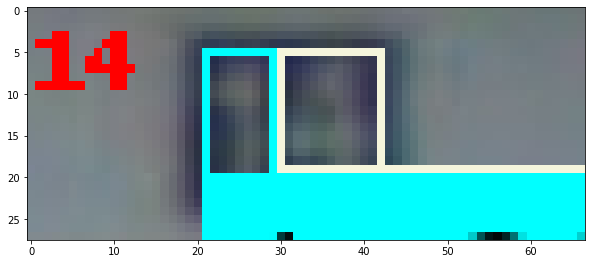

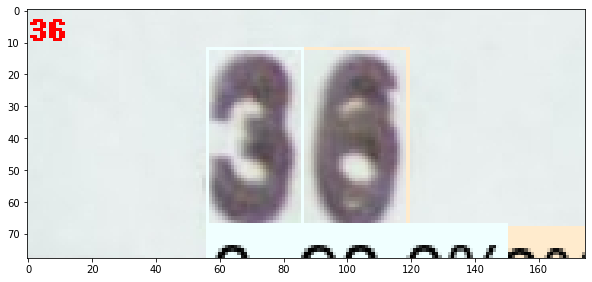

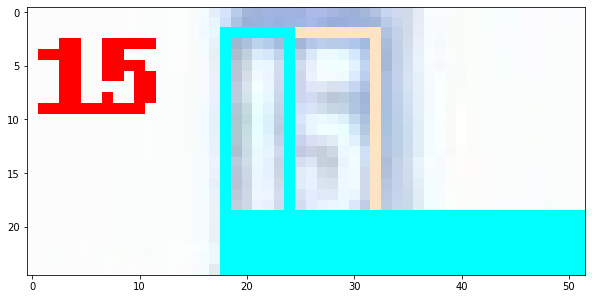

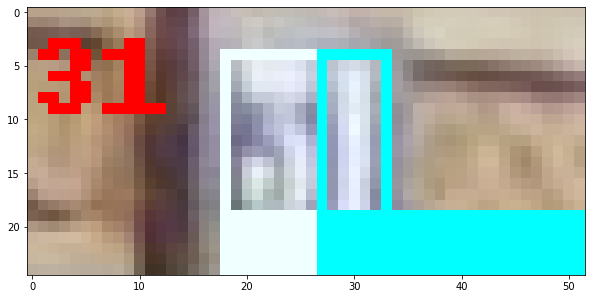

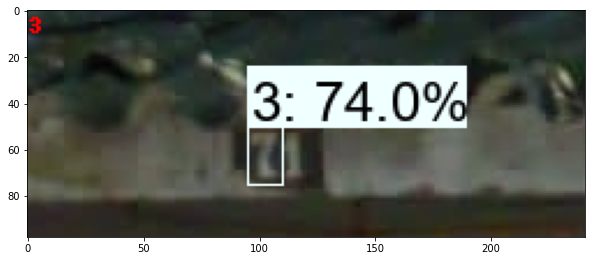

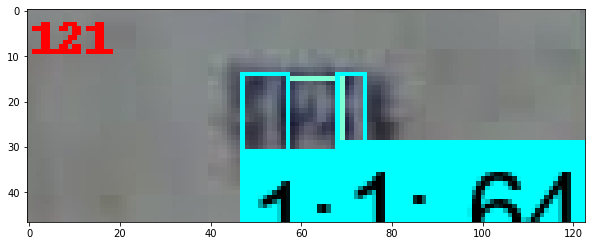

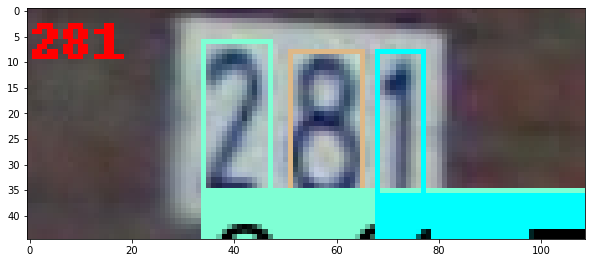

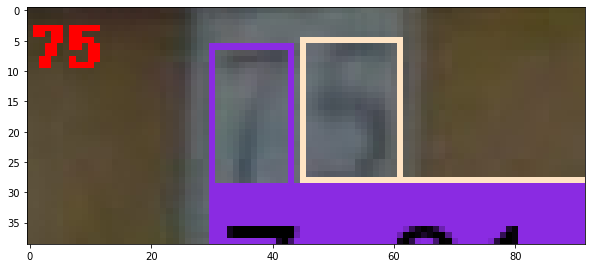

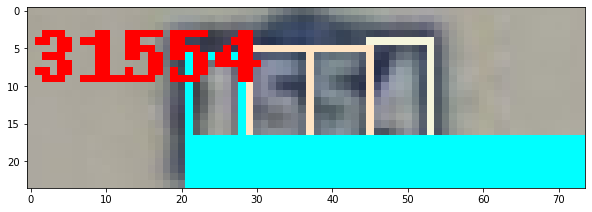

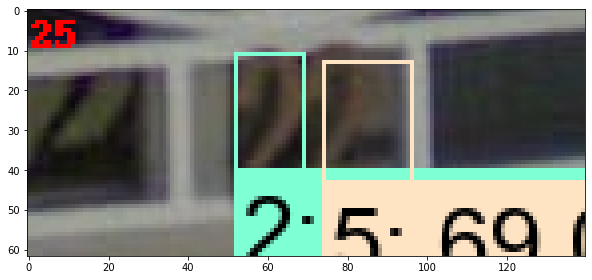

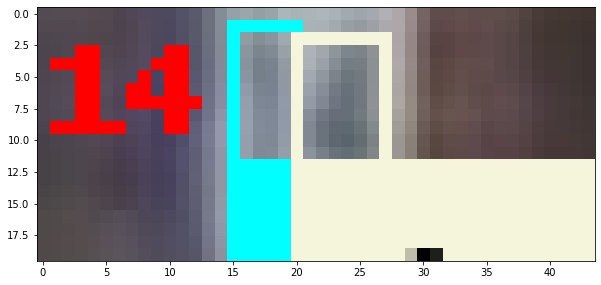

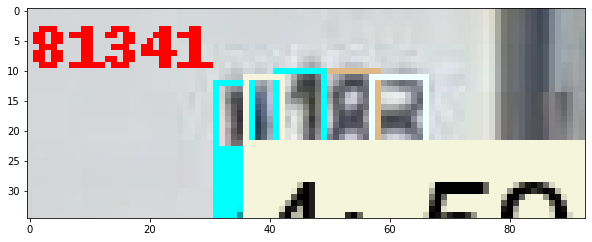

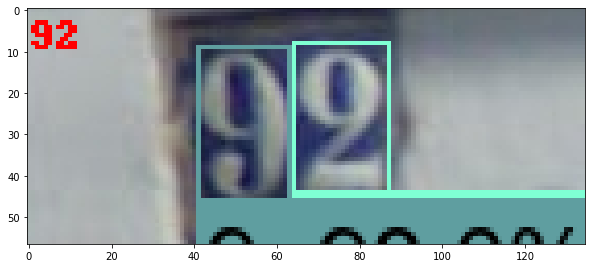

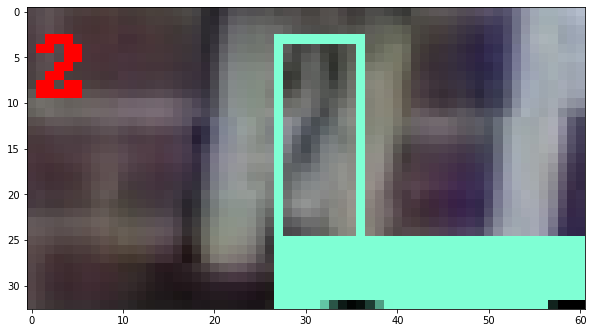

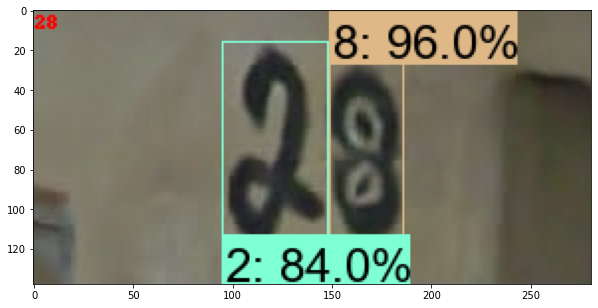

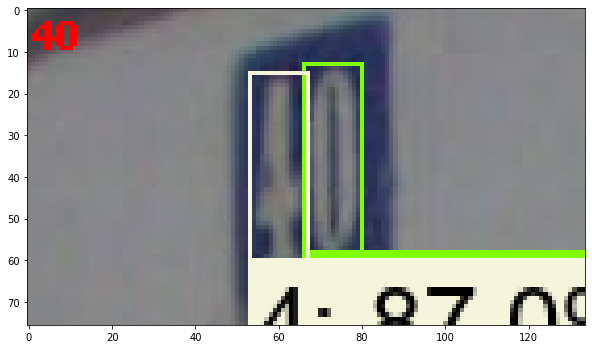

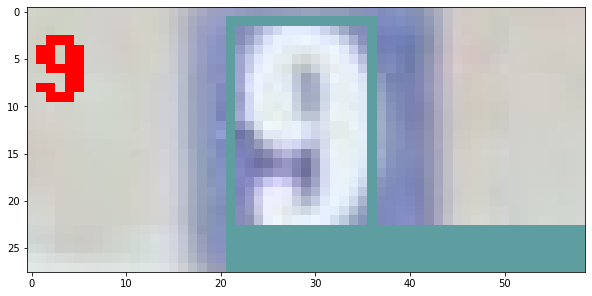

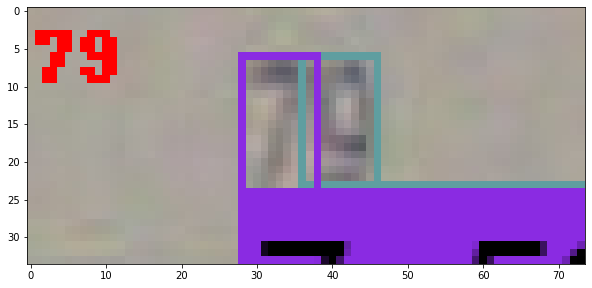

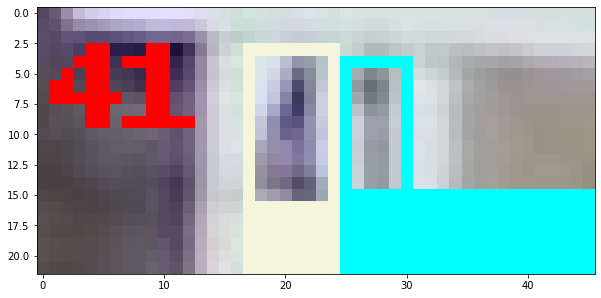

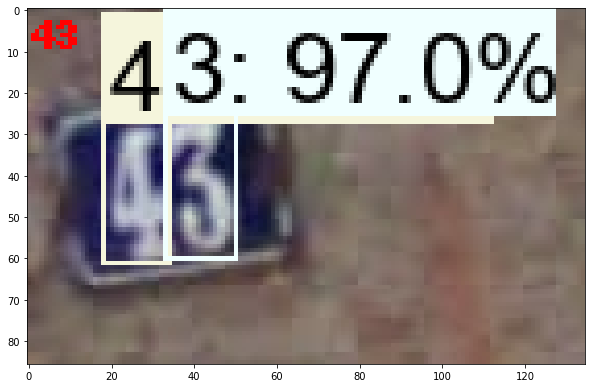

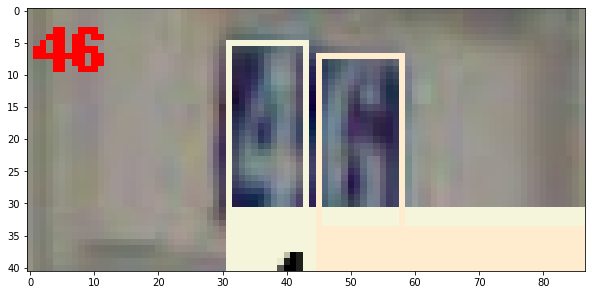

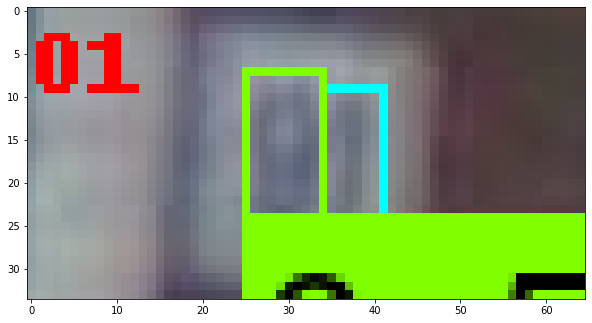

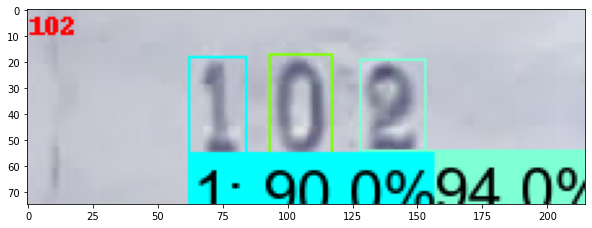

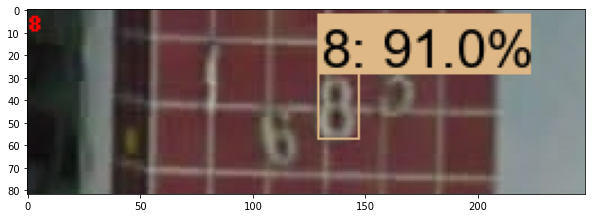

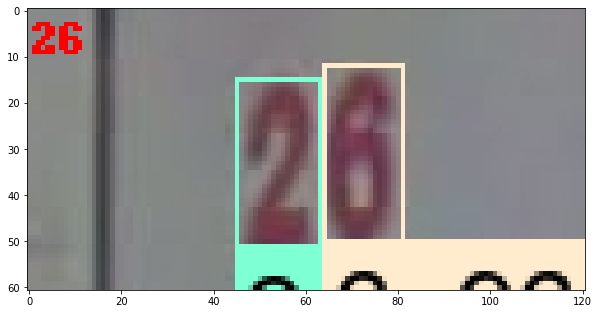

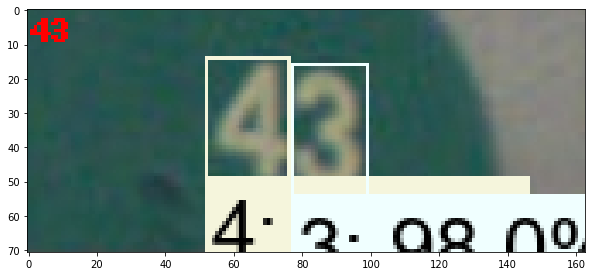

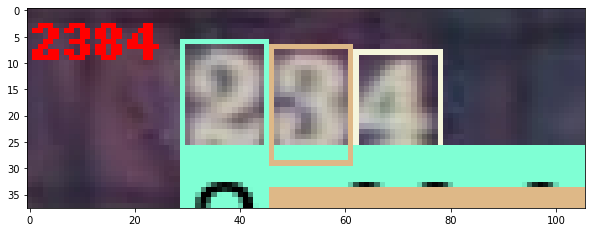

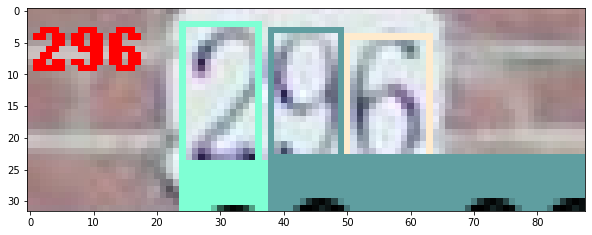

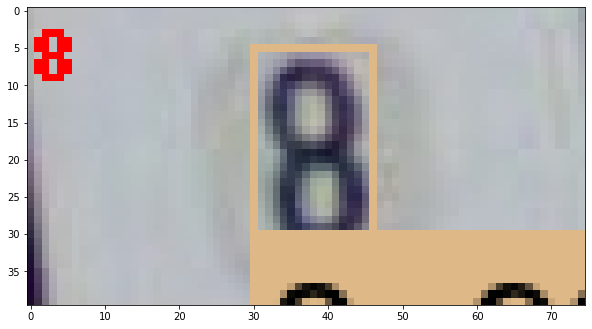

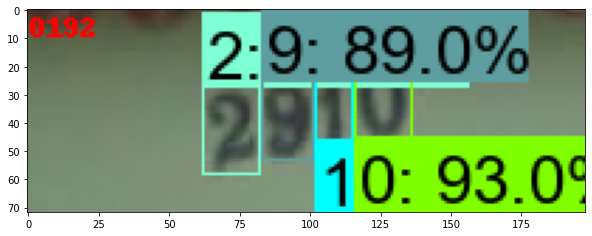

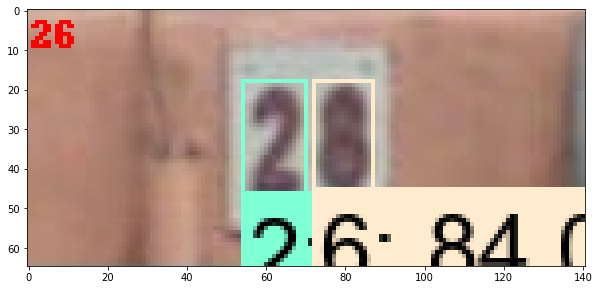

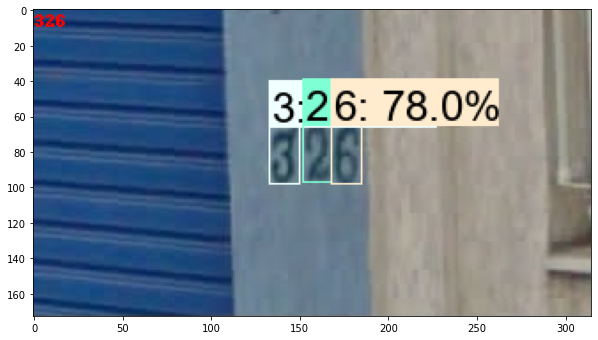

In [5]:
IMAGE_PATHS = os.listdir('./Imagenes/')
dict_classes =	{ 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open('./Imagenes/'+path))

with open('predictions.txt', 'w') as f:
    for image_path in IMAGE_PATHS:
        print(image_path)

        print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(image_path)
        height, width, channels = image_np.shape
        # Things to try:
        # Flip horizontally
        #image_np = np.fliplr(image_np).copy()

        # Convert image to grayscale
        # image_np = np.tile(
        #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
        input_tensor = tf.convert_to_tensor(image_np)
        # The model expects a batch of images, so add an axis with `tf.newaxis`.
        input_tensor = input_tensor[tf.newaxis, ...]

        # input_tensor = np.expand_dims(image_np, 0)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                       for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        #Define the parameters for the generation of the predictions on the image
        image_np_with_detections = image_np.copy()
        viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'],
              detections['detection_classes'],
              detections['detection_scores'],
              category_index,
              line_thickness=1,
              use_normalized_coordinates=True,
              max_boxes_to_draw=200,
              min_score_thresh=.50,
              agnostic_mode=False)

        # Apply the threshold on the values provided by the model
        detections['detection_classes'] = [*map(dict_classes.get, detections['detection_classes'])]
        scores = detections['detection_scores'][detections['detection_scores'] > 0.50]
        bb = detections['detection_boxes'][0:scores.size]
        classes = detections['detection_classes'][0:scores.size]

        # Write the Result on the image
        street_number = concatenate(bb,classes,height,width)
        img = Image.fromarray(np.uint8(image_np_with_detections)).convert('RGB')
        d1 = ImageDraw.Draw(img)
        d1.text((1, 1), street_number, fill=(255, 0, 0))
        plt.figure(figsize=(10,20))
        plt.imshow(img)
        img.save('./Prediciton/'+image_path)

        #Write the results on a Txt file
        f.write(image_path+' '+street_number)
        f.write('\n')

    plt.show()

## 5. Metrics of the Street Number Prediction

In [6]:
# Retrieve the information from the ground truth file
img_name_gt = []
class_name_gt = []
f = open("testset_gt.txt", "r")
for x in f:
    data = x.split()
    img_name_gt.append(data[0])
    class_name_gt.append(int(data[1]))
f.close() 

In [7]:
# Retrieve the information from the prediction
img_name_pred = []
class_name_pred = []
f = open("predictions.txt", "r")
for x in f:
    data = x.split()
    img_name_pred.append(data[0])
    class_name_pred.append(int(data[1]))
f.close() 

In [8]:
# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

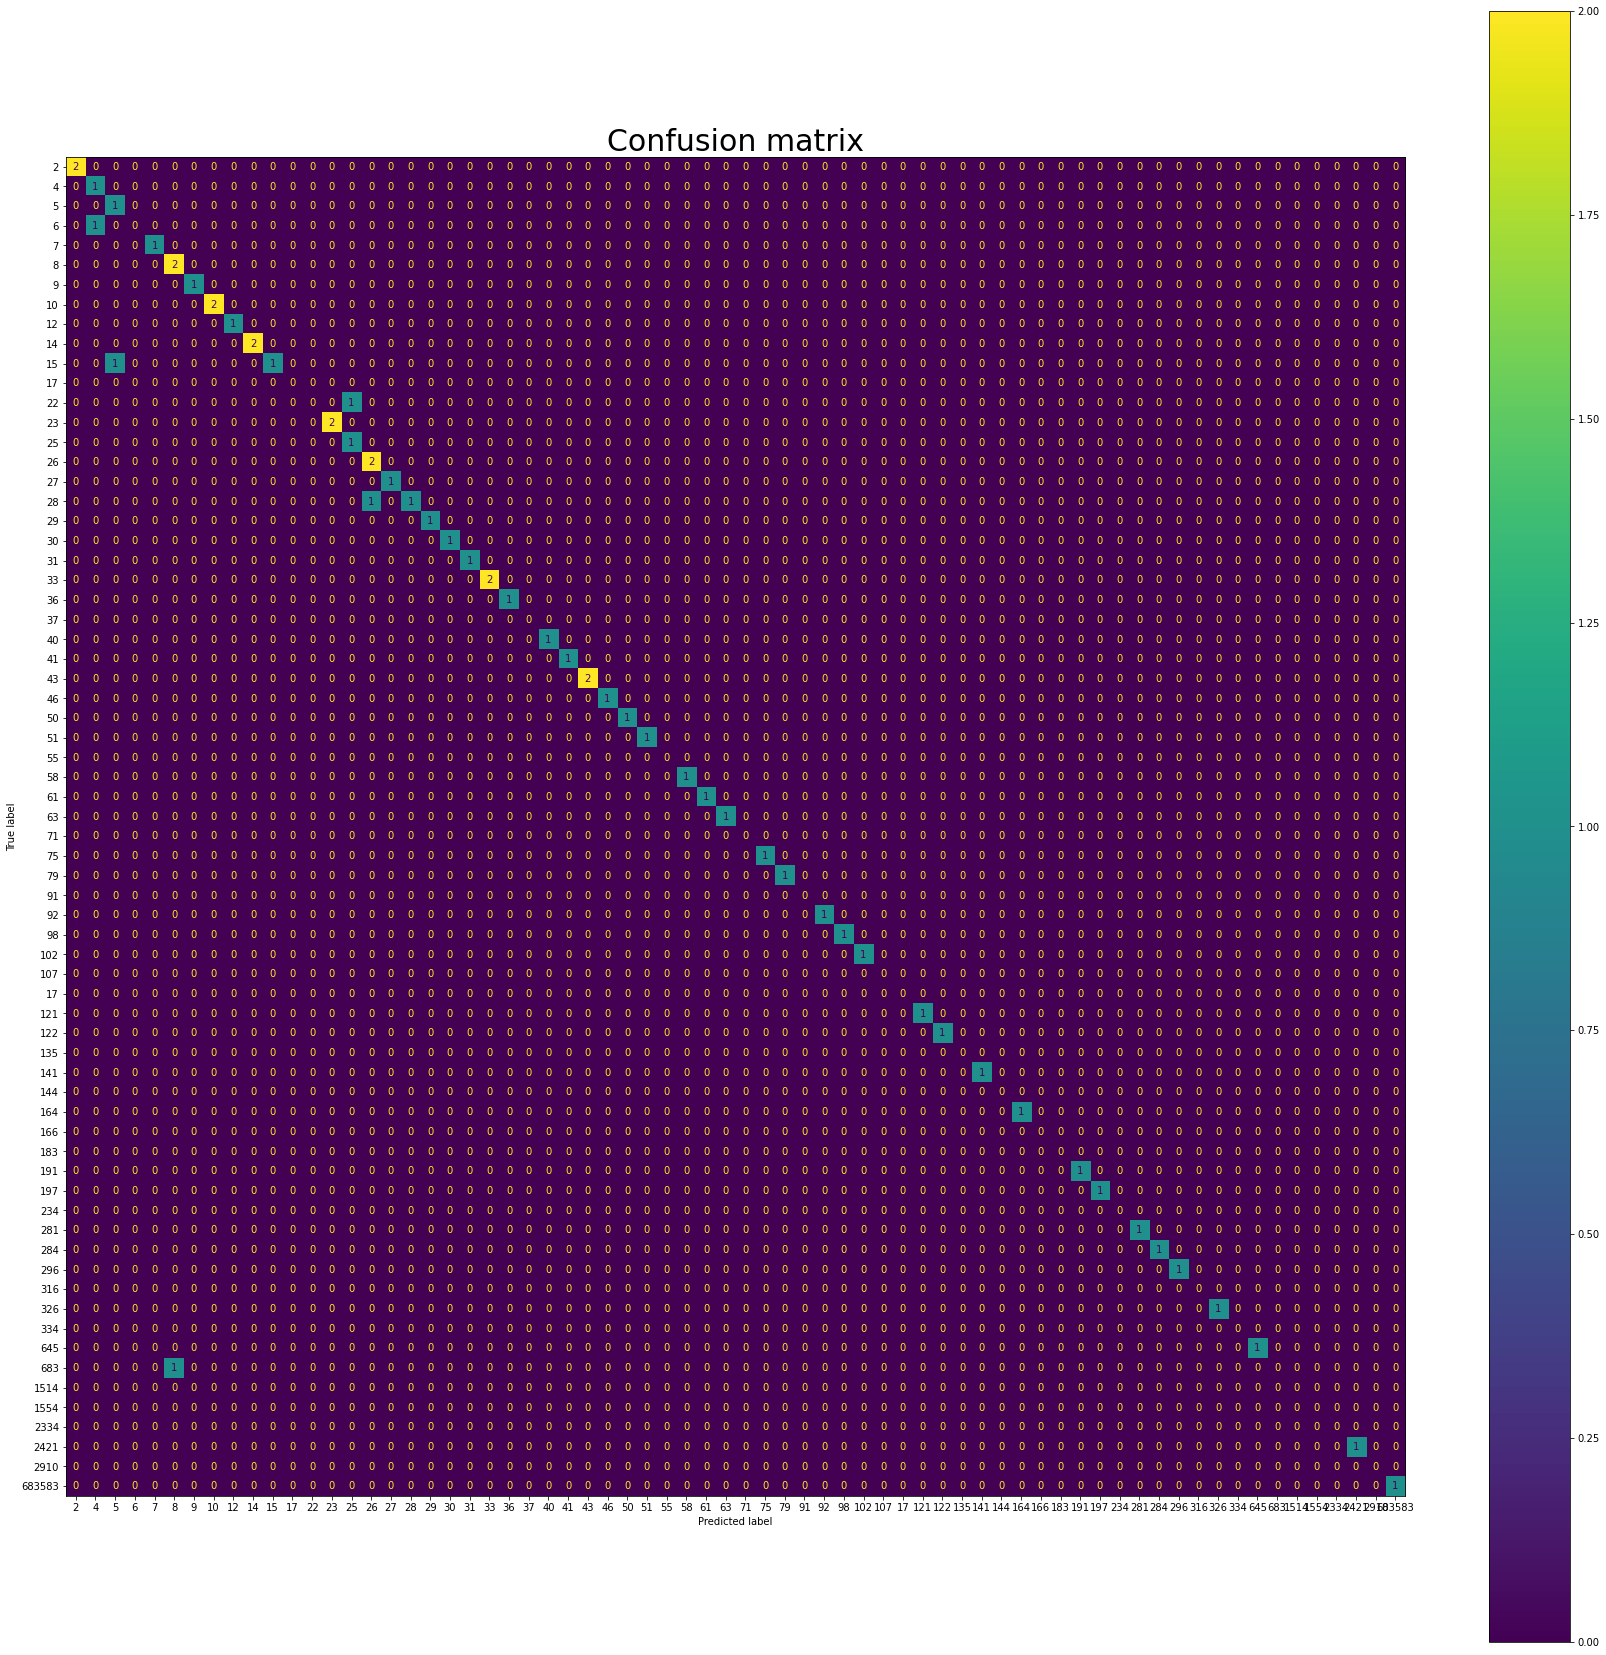

In [9]:
class_labels=[2,4,5,6,7,8,9,10,12,14,15,17,22,23,25,26,27,28,29,30,31,33,36,37,40,41,43,46,50,51,55,58,61,63,71,75,79,91,92,98,102,107,17,121,122,135,141,144,164,166,
183,191,197,234,281,284,296,316,326,334,645,683,1514,1554,2334,2421,2910,683583]

cm = confusion_matrix(class_name_gt, class_name_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_labels)
fig, ax = plt.subplots(figsize=(30,30))
title_font = {'size':'30'}  # Adjust to fit
plt.title('Confusion matrix', fontdict=title_font)
disp.plot(ax=ax)
plt.show()

In [10]:
print("The Precision, Recall and F1 of the model is: \n",classification_report(class_name_gt, class_name_pred, labels=class_labels))

The Precision, Recall and F1 of the model is: 
               precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         1
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         2
          17       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          23       1.00      1.00      1.00         2
          25       0.50      1.00      0.67         1
          26       0.67      1.00      0.80         2
          27       1.00      1.00